- 在本节，你将学习如何获取数据，选择模型并估计模型的参数，以便对新数据给出良好的预测。
    - 就像是物理学上第二困难的问题：仪器校准

### 学习目标：

**给定输入数据和相应的期望输出（ground truth**）以及**权重的初始值**，**模型输入数据（前向传播）**，然后通过把结果输出与ground truth进行比较来**评估误差**。为了**优化模型的参数**，其权重（即单位权重变化引起的误差变化，也即误差相对于参数的梯度）通过使用**对复合函数求导的链式法则进行计算（反向传播）**。然后，**权重的值沿导致误差减小的方向更新**。不断重复该过程直到在新数据上的**评估误差降至可接受的水平以下**。

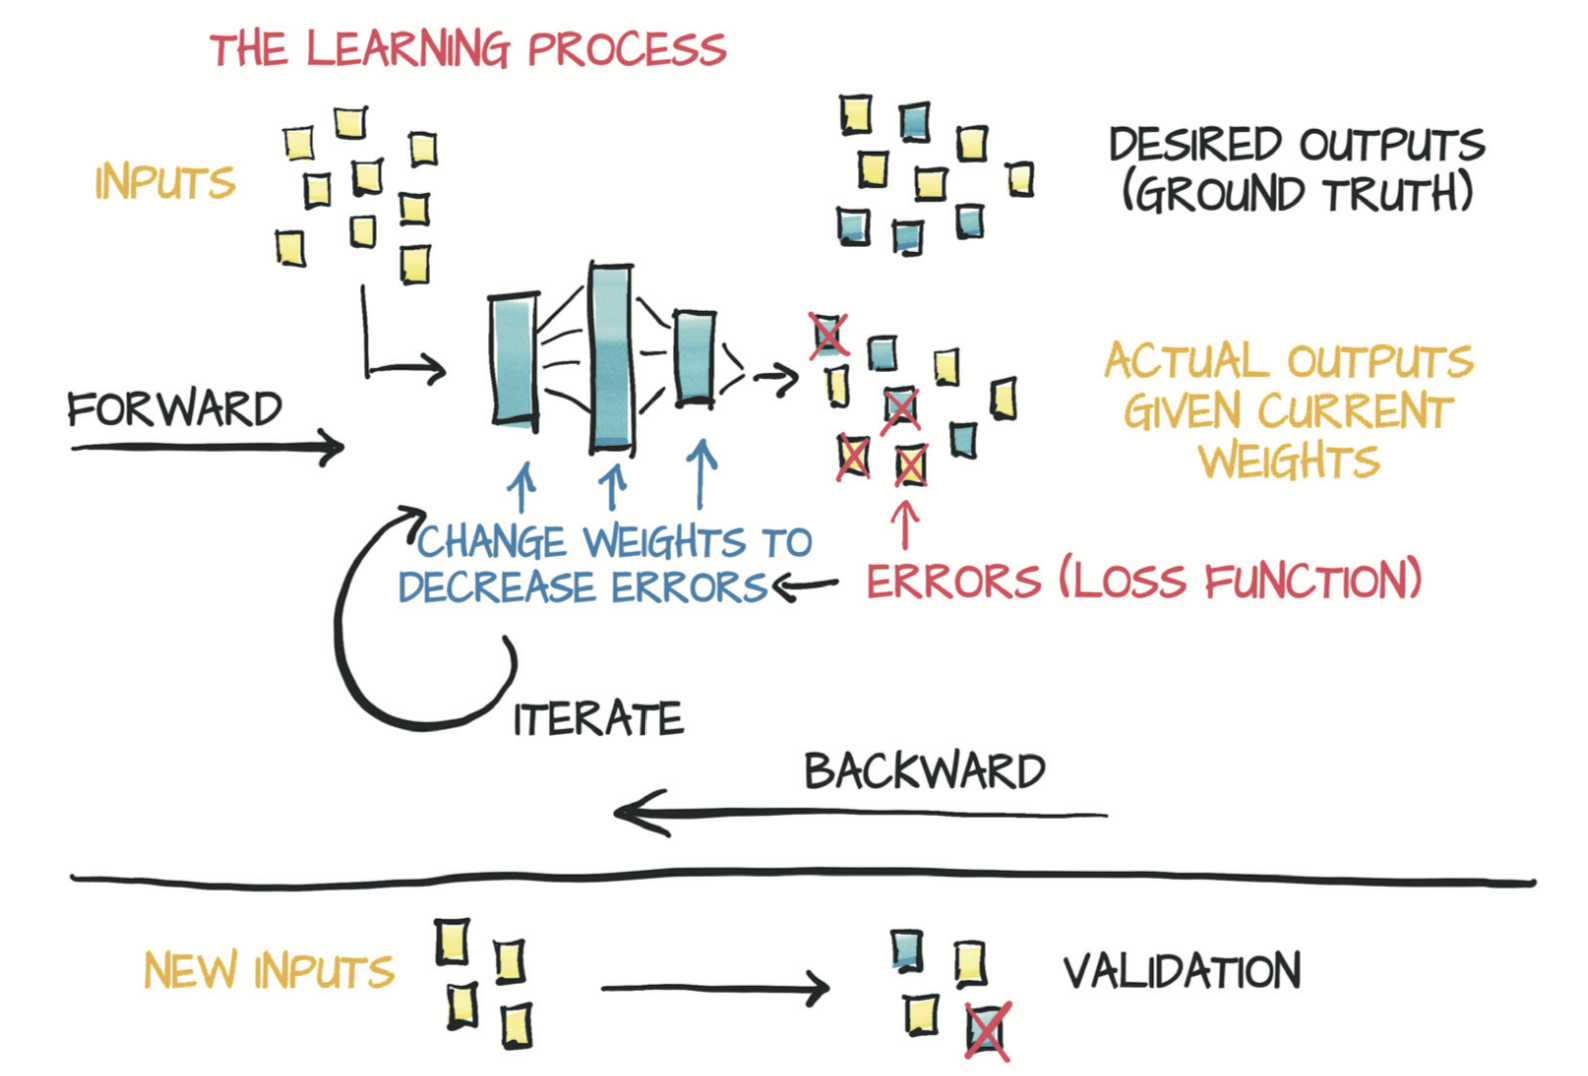

---

### 4.1.1 一个热门的问题

你有一个新的温度计，缺点是不显示单位。你用自己喜欢的单位建立一个读数和相应温度值的数据集，然后选择一个模型，并迭代调整单位的权重，直到误差的测量值足够低为止，最后你就可以在新温度计上进行准确读数了,并且是你喜欢的单位。


备注：未知温度 t_u , 实际温度t_c , 预测温度 t_p 。。。。实际温度和预测温度都是你喜欢的摄氏单位。

In [342]:
import torch

In [343]:
# 几周后，你观察到了这些数据集
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
    # t_c是摄氏度数，t_u是未知单位度数。
# 转化为张量
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)


### 4.1.2 选择线性模型作为首次尝试

构建线性模型： t_c = w * t_u + b        

(t_c是摄氏度数，t_u是未知单位度数。)

w 和 b 分别是权重weight和偏差bias，这是线性缩放的两个常用术语.

过程：通过已有的数据估算模型中的参数 w 和 b 。为了评估误差，我们在优化过程应以找到使损失函数(cost function)处于最低水平的 w 和 b 为目标。

### 4.1.3 你所需的是减少损失

损失函数（或成本函数）是输出为单个数值的函数，在学习过程中我们试图最小化它。损失函数通常是计算训练样本的期望输出与模型接收这些样本所产生的实际输出之间的差异.

损失函数有很多定义，这里采用平方误差函数 ： cost function = (t_p - t_c)**2 

补充：线性模型的损失函数应该是**凸形的（convex）**，以保证能够收敛到最小。但是深度神经网络的损失函数**不保证是凸的**

### 4.1.4 从问题到PyTorch

之前的步骤，定义了模型和损失函数。 现在需要启动学习过程并提供实际数据。

In [344]:
# 将模型 t_c = w*t_u + b 用python来表达。
def model(t_u,w,b):
    return w * t_u + b

    # 在你的模型中，参数是PyTorch标量（也称为零维张量），
        #并且乘积运算将使用广播（broadcast）来产生返回的张量。

In [345]:
# 将损失函数cost function 用python表达
def loss_fn(t_p,t_c):
    squared_diffs = (t_p-t_c)**2
    return squared_diffs.mean()   # torch.mean()

In [346]:
# 初始化参数
w = torch.ones(1)
b = torch.zeros(1)
# 一次预测值
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [347]:
# 评估误差——计算误差函数
loss = loss_fn(t_c = t_c ,t_p = t_p)
loss

tensor(1763.8846)

### 4.1.5 沿梯度向下

梯度下降（gradient descent）算法针对参数优化损失函数.

梯度下降是一个简单但可以令人惊讶地很好地扩展到具有数百万个参数的大型神经网络模型的方法。

---
对优化过程的卡通化描述，图中一个人用带有w和b的旋钮向使损耗减小的方向进行搜索

梯度下降没有太大不同，其想法是计算相对于每个参数的损失变化率，并沿损失减小的方向改变每个参数。当您摆弄旋钮时，可以通过对w和b进行很小的旋转来估计该变化率，以查看该邻域中的损失值变化了多少。
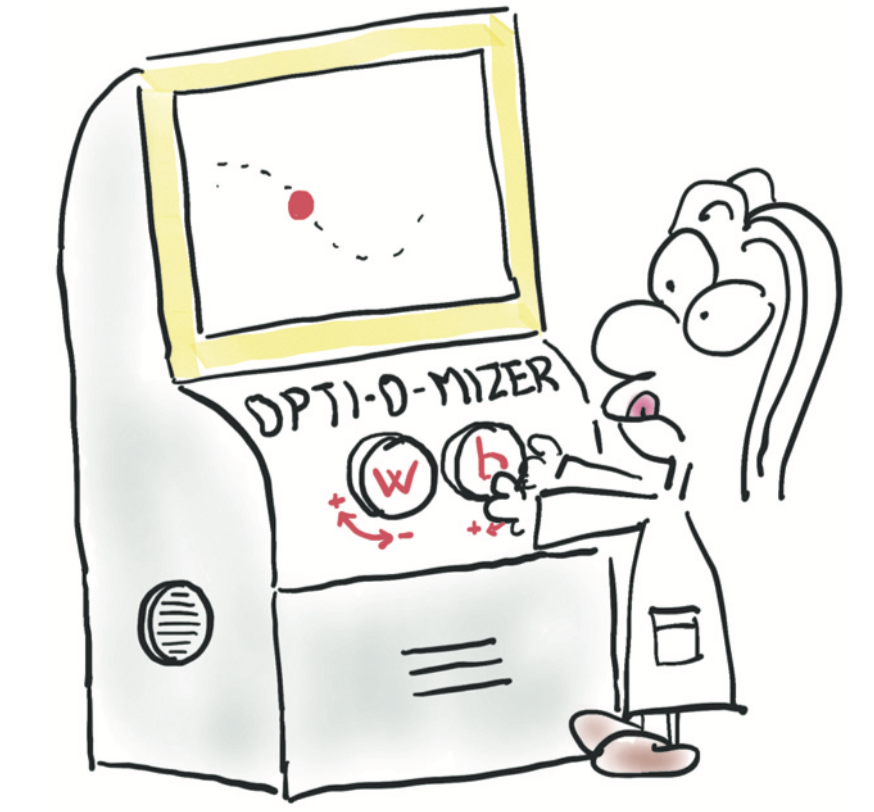

---

#### 梯度下降算法主要是两部分： 1.求参数在损失函数中的偏导数 2. 同步更新参数

In [348]:
# 损失函数随w变化的变化率(loss_rate_of_change_w)。 delta是w的微调幅度。
delta = 0.1

loss_left = loss_fn(model(t_u=t_u,w=w-delta,b=b),t_c)
loss_right = loss_fn(model(t_u=t_u,w=w+delta,b=b),t_c)
loss_rate_of_change_w = (loss_right - loss_left) / (delta*2)  

In [349]:
# 同样的方式，损失函数随b变化的变化率(loss_rate_of_change_b)。 delta是b的微调幅度。
delta = 0.1

loss_left = loss_fn(model(t_u=t_u,w=w,b=b-delta),t_c)
loss_right = loss_fn(model(t_u=t_u,w=w,b=b+delta),t_c)
loss_rate_of_change_b = (loss_right - loss_left) / (delta*2)  

In [350]:
# 同步更新参数(参数必须在全部求出偏导之后，再一起更新)

learning_rate = 1e-2  # 学习率，影响了参数的迭代步长，最后也影响了损失函数收敛的步长，太小太大都不行。
w = w-learning_rate*loss_rate_of_change_w
b = b-learning_rate*loss_rate_of_change_b

### 4.1.6 进行分析 并 改进

通过重复评估模型和损失以搜索w和b附近的损失函数的行为来计算变化率，并不能很好地适应具有许多参数的模型。

注意之前 theta 和 learning_rate 都要依据模型的尺寸来做适合地赋值。

替代变化率。要计算损失值相对于参数的导数，你可以应用链式规则，计算损失函数相对于其输入（即模型的输出）的导数乘以模型相对于参数的导数

### 损失函数相对于模型参数的导数
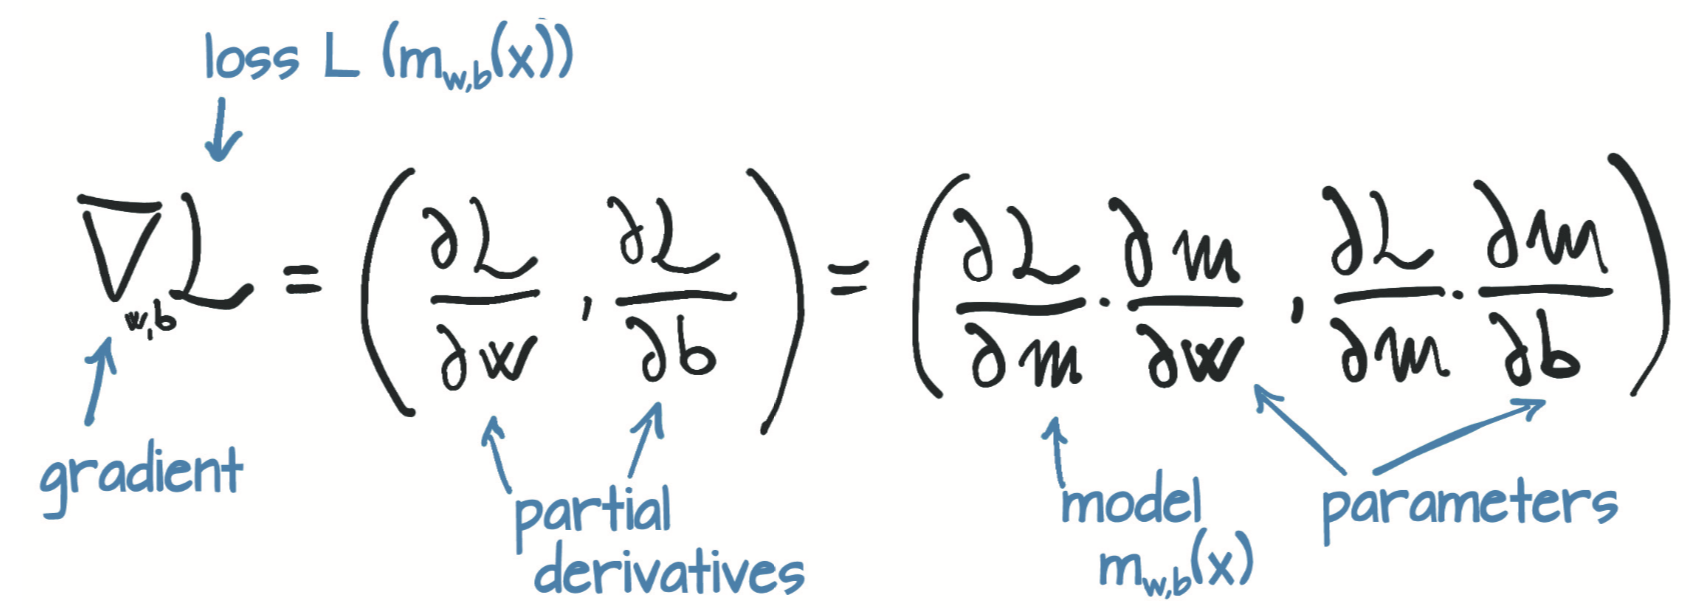

### 链式求导的规则来重写返回损失相对于w 和 b的梯度的函数
- loss'(w) = loss'(model) * model'(w) 
- loss'(b) = loss'(model) * model'(b) 

In [430]:
# 注意：这里写了dloss_fn和dmodel函数并不是为了取代model和loss函数，而是梯度函数grad_fn的需要。
    # 实际上，两边是根本是不同作用的函数，一边是函数求偏导，一边是函数本身。
        # 另外，一下这些只是服务于反向传播的求导的手写步骤，
            # 在用了Pytorch的自动求导autograd之后，这些手写步骤都不需要了。

    # 重写损失函数的求导表达式    # 求编导 loss'(model)
def dloss_fn(t_p, t_c):      
    dsq_diffs = 2*(t_p - t_c)  
    return dsq_diffs

    # 重写模型的求导表达式     # 求偏导 model'(w)
def dmodel_dw(t_u,w,b):
    return t_u    

def dmodel_db(t_u,w,b):  # 求偏导 model'(b)
    return 1.0


# 返回损失相对于w 和 b的梯度的函数  
    # 注意参数： 输入值、输出值、权置参数
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dw = dloss_fn(t_p, t_c) * dmodel_dw(t_u, w, b)
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.mean(), dloss_db.mean()])

In [352]:
# 语法补充：关于 torch.stack() torch.cat()
seq = [torch.ones(2,3),torch.zeros(2,3)]

cat = torch.cat(seq,dim=0,out=None) 
    # 沿着dim连接seq中的tensor, 所有的tensor必须有相同的size或为empty， 
        #其相反的操作为 torch.split() 和torch.chunk()
stack = torch.stack(seq, dim=0, out=None) #同上

cat,cat.shape,stack,stack.shape

# 注: .cat 和 .stack的区别在于 cat会增加现有维度的值,可以理解为续接，
  # stack会新加增加一个维度，可以理解为叠加

(tensor([[1., 1., 1.],
         [1., 1., 1.],
         [0., 0., 0.],
         [0., 0., 0.]]),
 torch.Size([4, 3]),
 tensor([[[1., 1., 1.],
          [1., 1., 1.]],
 
         [[0., 0., 0.],
          [0., 0., 0.]]]),
 torch.Size([2, 2, 3]))

---

### 4.1.7 训练循环

从参数的暂定值开始，你可以迭代地对其应用更新以进行固定次数的迭代或者直到w和b停止改变为止。你可以使用多个停止条件，但是现在以固定迭代次数为例。


术语：
- Epoch 使用训练集的全部数据对模型进行一次完整训练，被称之为“一代训练”
- Batch 使用训练集中的一小部分样本对模型权重进行一次反向传播的参数更新，这一小部分样本被称为“一批数据”
- Iteration 使用一个Batch数据对模型进行一次参数更新的过程，被称之为“一次训练”

---

In [353]:
# 测试
a,b = [1,2]
a,b

(1, 2)

In [354]:
# 测试
params = torch.tensor([1.,0.])
w,b = params
params,w,b

(tensor([1., 0.]), tensor(1.), tensor(0.))

In [355]:
# w,b = torch.rand(1,2) 这是错的
torch.rand(1,2)

tensor([[0.0297, 0.9218]])

In [356]:
# 测试  标量张量 转为 Python浮点数
print('%f' % float(torch.tensor(1.)))  

1.000000


In [357]:
# 测试
print('out : %d ',1)
print('out : %d %d' % (1,2) ) # %后面跟元组
print('out ：' , 1,2)
print('out ：' , (1,2))

out : %d  1
out : 1 2
out ： 1 2
out ： (1, 2)


In [358]:
# 训练循环函数
    # params = [w,b]    n_epochs是epoch迭代的次数
        # print_params=True,verbose = 1 用于控制打印效果
def training_loop(n_epochs,learning_rate,params,t_u,t_c,
                  print_params=True,verbose = 1):
    for epach in range(1,n_epochs+1):
        
        w,b = params
        t_p = model(t_u=t_u,w=w,b=b)  # 前向传播  求预测值
        loss = loss_fn(t_p=t_p,t_c=t_c) # 求损失
        grad = grad_fn(t_u= t_u,t_c=t_c,t_p=t_p,w=w,b=b) # 反向传播 求grad

        params = params - learning_rate*grad  # 同步更新参数
    
        if epach % verbose==0:    # 控制打印效果
            print('Epoch: %d, Loss: %f' % (epach,float(loss)) ) 
            if print_params:
                print('params: ' , params)
                print('grad  : ' , grad)
                
    return params  #返回拟合的参数

In [359]:
# 调用训练循环函数
# params = torch.randn(1,2) 错误
params = torch.tensor([1.,0.])
training_loop(n_epochs=10,learning_rate=1e-2,params=params,t_u=t_u,t_c=t_c)

    # 执行结果显示，loss越来越大。 问题在Learning_rate太大了。

Epoch: 1, Loss: 1763.884644
params:  tensor([-44.1730,  -0.8260])
grad  :  tensor([4517.2964,   82.6000])
Epoch: 2, Loss: 5802484.500000
params:  tensor([2568.4011,   45.1637])
grad  :  tensor([-261257.4062,   -4598.9707])
Epoch: 3, Loss: 19408031744.000000
params:  tensor([-148527.7344,   -2616.3933])
grad  :  tensor([15109615.0000,   266155.7188])
Epoch: 4, Loss: 64915909902336.000000
params:  tensor([8589997.0000,  151310.8750])
grad  :  tensor([-8.7385e+08, -1.5393e+07])
Epoch: 5, Loss: 217130439561707520.000000
params:  tensor([-4.9680e+08, -8.7510e+06])
grad  :  tensor([5.0539e+10, 8.9023e+08])
Epoch: 6, Loss: 726257020202974707712.000000
params:  tensor([2.8732e+10, 5.0610e+08])
grad  :  tensor([-2.9229e+12, -5.1486e+10])
Epoch: 7, Loss: 2429181687085405986357248.000000
params:  tensor([-1.6617e+12, -2.9270e+10])
grad  :  tensor([1.6904e+14, 2.9776e+12])
Epoch: 8, Loss: 8125117236949438203699396608.000000
params:  tensor([9.6102e+13, 1.6928e+12])
grad  :  tensor([-9.7764e+15, -1

tensor([3.2144e+17, 5.6621e+15])

In [360]:
# 减小lreaning_rate 再次调用训练循环函数
# params = torch.randn(1,2) 错误
params = torch.tensor([1.,0.])
training_loop(n_epochs=10,learning_rate=1e-4,params=params,t_u=t_u,t_c=t_c)

    # 执行结果显示，loss越来愈小。 

Epoch: 1, Loss: 1763.884644
params:  tensor([ 0.5483, -0.0083])
grad  :  tensor([4517.2964,   82.6000])
Epoch: 2, Loss: 323.090546
params:  tensor([ 0.3623, -0.0118])
grad  :  tensor([1859.5493,   35.7843])
Epoch: 3, Loss: 78.929634
params:  tensor([ 0.2858, -0.0135])
grad  :  tensor([765.4666,  16.5122])
Epoch: 4, Loss: 37.552845
params:  tensor([ 0.2543, -0.0143])
grad  :  tensor([315.0790,   8.5787])
Epoch: 5, Loss: 30.540285
params:  tensor([ 0.2413, -0.0149])
grad  :  tensor([129.6733,   5.3127])
Epoch: 6, Loss: 29.351152
params:  tensor([ 0.2360, -0.0153])
grad  :  tensor([53.3496,  3.9682])
Epoch: 7, Loss: 29.148882
params:  tensor([ 0.2338, -0.0156])
grad  :  tensor([21.9304,  3.4148])
Epoch: 8, Loss: 29.113848
params:  tensor([ 0.2329, -0.0159])
grad  :  tensor([8.9964, 3.1869])
Epoch: 9, Loss: 29.107145
params:  tensor([ 0.2325, -0.0162])
grad  :  tensor([3.6721, 3.0930])
Epoch: 10, Loss: 29.105242
params:  tensor([ 0.2324, -0.0166])
grad  :  tensor([1.4803, 3.0544])


tensor([ 0.2324, -0.0166])

说明：之前是动态调整learning_rate来解决loss收敛的问题。其实在实际操作，还有更多手段，比如“特征缩放”和“优化器”。

### 特征缩放
特征缩放：使得输入参数的尺度在(-1,1)范围，且输入参数之间相差更小的尺度。

补充: 特征缩放和学习率都对梯度下降有影响。所以要注意两者调整。

In [367]:
# 特征缩放。  
t_un = (t_u - t_u.mean())/t_u.std()

# 将n_epochs设置更大，再次训练
params = training_loop(n_epochs=10000,learning_rate=1e-3,
              params=params,t_u=t_un,t_c=t_c,verbose=1000)

        # 特征缩放 、learning_rate=1e-3 之后 
            #Epoch: 10000, Loss: 2.927645
            #params:  tensor([ 9.0346, 10.4998])
            #grad  :  tensor([-0.0005, -0.0005])

Epoch: 1000, Loss: 2.927645
params:  tensor([ 9.0346, 10.4998])
grad  :  tensor([-0.0005, -0.0005])
Epoch: 2000, Loss: 2.927645
params:  tensor([ 9.0346, 10.4998])
grad  :  tensor([-0.0005, -0.0005])
Epoch: 3000, Loss: 2.927645
params:  tensor([ 9.0346, 10.4998])
grad  :  tensor([-0.0005, -0.0005])
Epoch: 4000, Loss: 2.927645
params:  tensor([ 9.0346, 10.4998])
grad  :  tensor([-0.0005, -0.0005])
Epoch: 5000, Loss: 2.927645
params:  tensor([ 9.0346, 10.4998])
grad  :  tensor([-0.0005, -0.0005])
Epoch: 6000, Loss: 2.927645
params:  tensor([ 9.0346, 10.4998])
grad  :  tensor([-0.0005, -0.0005])
Epoch: 7000, Loss: 2.927645
params:  tensor([ 9.0346, 10.4998])
grad  :  tensor([-0.0005, -0.0005])
Epoch: 8000, Loss: 2.927645
params:  tensor([ 9.0346, 10.4998])
grad  :  tensor([-0.0005, -0.0005])
Epoch: 9000, Loss: 2.927645
params:  tensor([ 9.0346, 10.4998])
grad  :  tensor([-0.0005, -0.0005])
Epoch: 10000, Loss: 2.927645
params:  tensor([ 9.0346, 10.4998])
grad  :  tensor([-0.0005, -0.0005])

### 数据绘图

特征缩放 、learning_rate=1e-3 之后 
- Epoch: 10000, Loss: 2.927645
- params:  tensor([ 9.0346, 10.4998])
- grad  :  tensor([-0.0005, -0.0005])

In [400]:
import matplotlib.pyplot as plt
%matplotlib inline

In [411]:
# 根据拟合的权置参数，拿到预测值
w,b = params
t_p = model(t_un,w,b)
t_p

tensor([ 1.8580, 12.7005, 13.9350, 26.6561, 12.9152,  8.9432,  0.8918, -5.6029,
         8.6748, 15.1159, 19.4099])

In [427]:
# 测试
t_p,t_p.detach()
    # Returns a new Variable, detached from the current graph.
        # detach()返回张量的属性中requires_grad=False

(tensor([ 1.8580, 12.7005, 13.9350, 26.6561, 12.9152,  8.9432,  0.8918, -5.6029,
          8.6748, 15.1159, 19.4099]),
 tensor([ 1.8580, 12.7005, 13.9350, 26.6561, 12.9152,  8.9432,  0.8918, -5.6029,
          8.6748, 15.1159, 19.4099]))

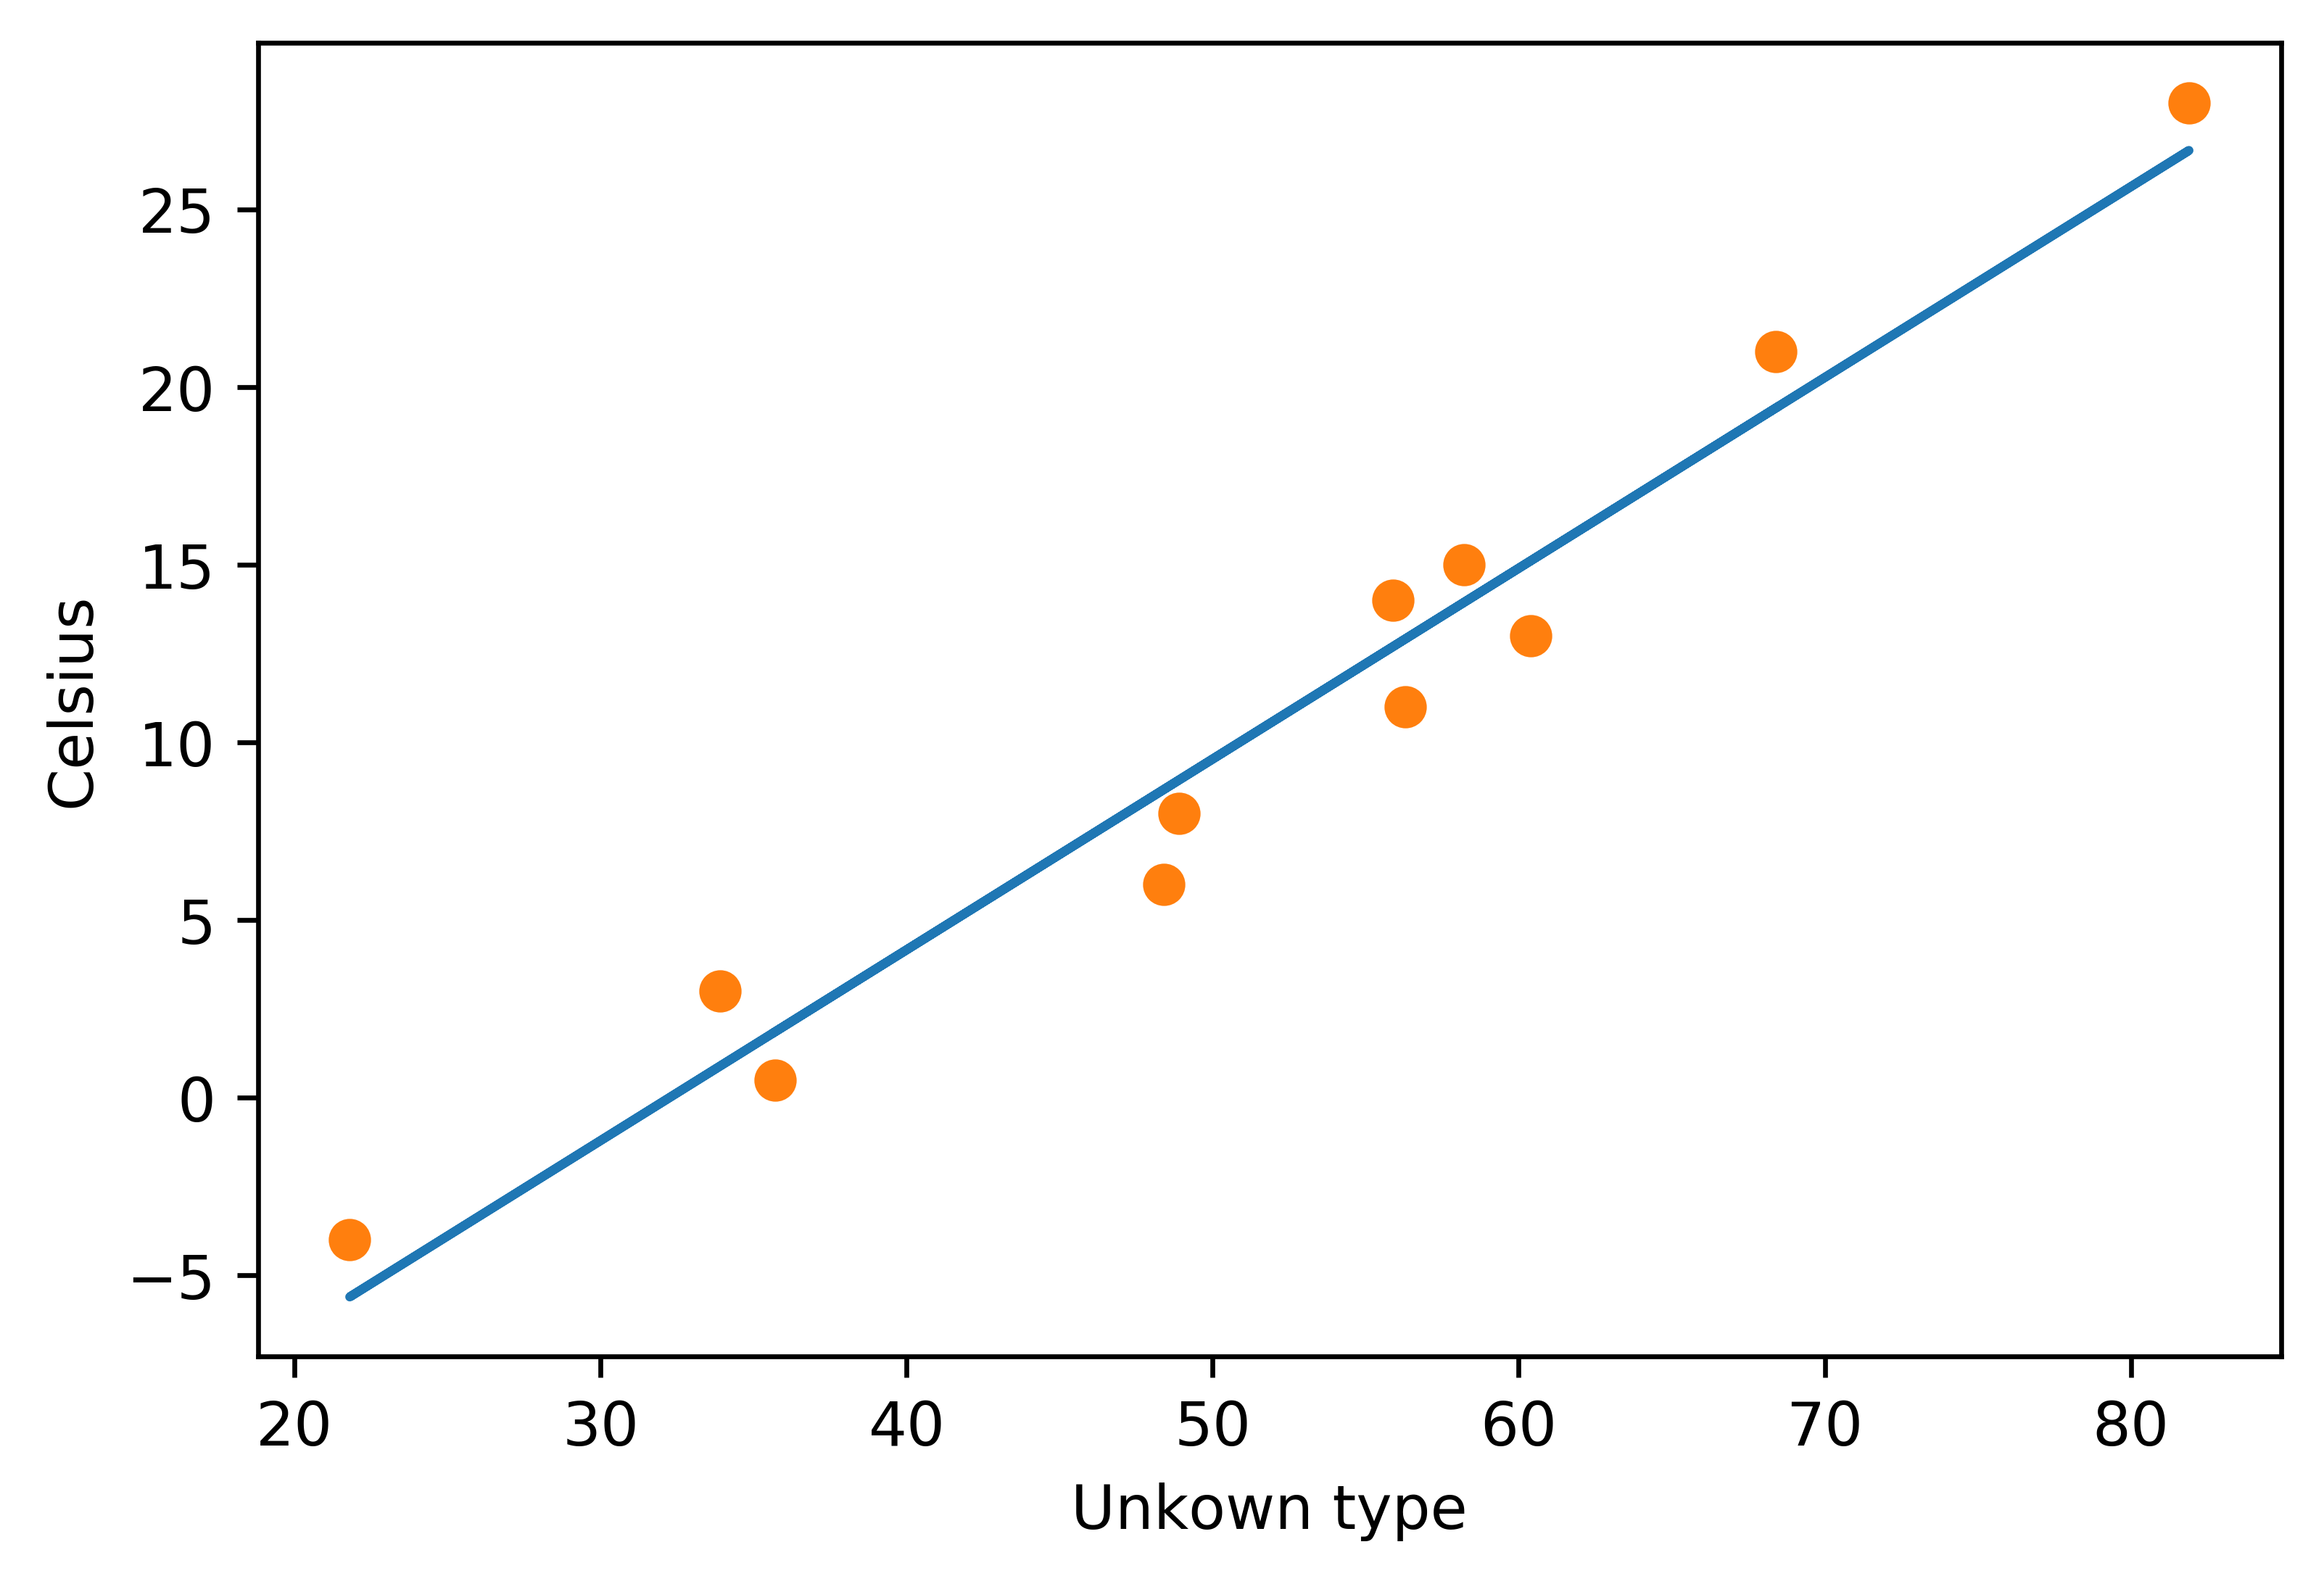

In [429]:
plt.figure(dpi=600)
# 设置轴的标签
plt.xlabel(xlabel='Unkown type')
plt.ylabel(ylabel='Celsius')
# 线性拟合模型（实线）与输入数据（圆圈）
plt.plot(t_u.numpy(),t_p.detach().numpy() ) # 拟合模型
    # .detach() ?
            #  Can't call numpy() on Variable that requires grad. 
                # Use var.detach().numpy() instead.
plt.plot(t_u.numpy(),t_c.numpy(),'o') # ground true